In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import re # We'll need this for cleaning the ingredient names

# Load the dataset
try:
    df = pd.read_csv('IndianFoodDatasetCSV.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'IndianFoodDatasetCSV.csv' was not found.")
    # Exit if the file is not found
    exit()

Dataset loaded successfully.


In [16]:
# Create an empty graph
G = nx.Graph()

# Iterate over each recipe to get ingredient combinations
for _, row in df.iterrows():
    # Split the ingredients string into a list and clean up whitespace
    ingredients = [ing.strip().lower() for ing in str(row['TranslatedIngredients']).split(',') if ing.strip() and ing.strip().lower() != 'nan']
    
    # Use a regular expression to remove numbers and common measurement units
    cleaned_ingredients = []
    for ing in ingredients:
        # Regex to match numbers (with or without decimal) and common units
        ing = re.sub(r'(\b\d+(\.\d+)?\s*(cup|teaspoon|tablespoon|tsp|tbsp|grams|g|kg|litre|ml|pinch|dash|clove|slice|pieces)s?\b|\b\d+(\.\d+)?\b)', '', ing, flags=re.I).strip()
        if ing: # Ensure we don't add empty strings
            cleaned_ingredients.append(ing)

    # Use combinations to get all unique pairs of ingredients from a single recipe
    ingredient_pairs = list(combinations(cleaned_ingredients, 2))
    
    # Add nodes and weighted edges to the graph
    for ingredient1, ingredient2 in ingredient_pairs:
        # Sort the pair to ensure consistency (e.g., ('a', 'b') is the same as ('b', 'a'))
        pair = tuple(sorted((ingredient1, ingredient2)))
        
        # Add a node for each ingredient
        G.add_node(ingredient1)
        G.add_node(ingredient2)
        
        # If the edge already exists, increment its weight. Otherwise, set weight to 1.
        if G.has_edge(pair[0], pair[1]):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)

print(f"Network created with {G.number_of_nodes()} nodes (ingredients) and {G.number_of_edges()} edges (co-occurrences).")



Network created with 15816 nodes (ingredients) and 286691 edges (co-occurrences).



Top 10 Most Connected Ingredients (by Degree):
- salt - to taste: 0.4642
- sunflower oil: 0.2048
- / turmeric powder (haldi): 0.1993
- red chilli powder: 0.1806
- onion - finely chopped: 0.1654
- lemon juice: 0.1638
- sugar: 0.1419
- extra virgin olive oil: 0.1376
- cumin seeds (jeera): 0.1342
- garlic: 0.1325

Top 10 Most Common Ingredient Pairs (by Co-occurrence Count):
- 'salt - to taste' and '/ turmeric powder (haldi)': appear together in 1188 recipes.
- 'salt - to taste' and 'sunflower oil': appear together in 1166 recipes.
- 'salt - to taste' and 'red chilli powder': appear together in 832 recipes.
- 'salt - to taste' and 'cumin seeds (jeera)': appear together in 686 recipes.
- 'salt - to taste' and 'onion - finely chopped': appear together in 594 recipes.
- 'salt - to taste' and 'sprig curry leaves': appear together in 535 recipes.
- '/ turmeric powder (haldi)' and 'sunflower oil': appear together in 512 recipes.
- 'salt - to taste' and 'coriander powder (dhania)': appear toget

C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

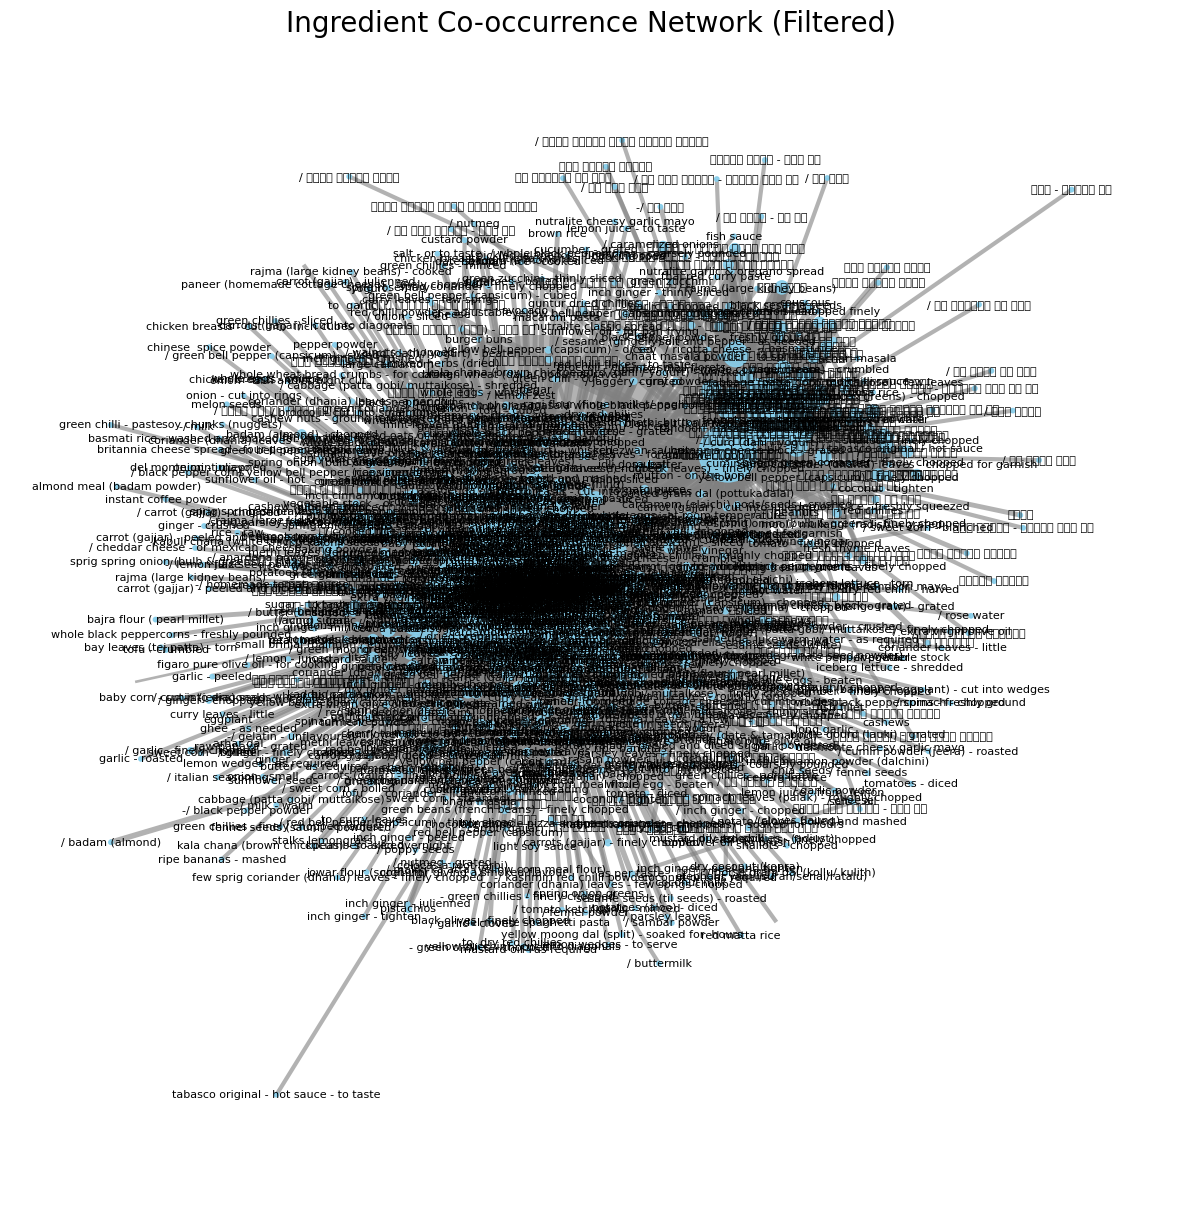

In [17]:
# Find the most connected ingredients by degree centrality
print("\nTop 10 Most Connected Ingredients (by Degree):")
degree_centrality = nx.degree_centrality(G)
top_ingredients = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
for ingredient, centrality in top_ingredients[:10]:
    print(f"- {ingredient}: {centrality:.4f}")

# Find the most commonly paired ingredients by edge weight
print("\nTop 10 Most Common Ingredient Pairs (by Co-occurrence Count):")
top_pairs = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for u, v, data in top_pairs[:10]:
    print(f"- '{u}' and '{v}': appear together in {data['weight']} recipes.")

# Create a filtered graph for better visualization (only show strong connections)
# You can adjust this threshold to show more or fewer connections
filtered_G = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] > 5: # Filter for edges that co-occur at least 5 times
        filtered_G.add_edge(u, v, weight=data['weight'])

print(f"\nFiltered network for visualization has {filtered_G.number_of_nodes()} nodes and {filtered_G.number_of_edges()} edges.")

# Set up the visualization
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(filtered_G, k=0.15, iterations=50, seed=42)

# Draw the nodes, with a size based on degree
node_size = [filtered_G.degree(node) * 10 for node in filtered_G.nodes()]
nx.draw_networkx_nodes(filtered_G, pos, node_color='skyblue', node_size=node_size, alpha=0.9)

# Draw the edges
edge_width = [d['weight'] / 2 for u, v, d in filtered_G.edges(data=True)]
nx.draw_networkx_edges(filtered_G, pos, edge_color='gray', width=edge_width, alpha=0.6)

# Draw the labels
nx.draw_networkx_labels(filtered_G, pos, font_size=8, font_family='sans-serif')

plt.title("Ingredient Co-occurrence Network (Filtered)", fontsize=20)
plt.axis('off')
plt.show()


In [29]:
# Set the minimum weight threshold for an edge to be included in the new graph
# You can adjust this value to control the density of the network.
min_weight_threshold = 200

# Create a new graph with only the edges that meet the weight threshold
dense_G = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] >= min_weight_threshold:
        dense_G.add_edge(u, v, weight=data['weight'])

print(f"Dense graph created with {dense_G.number_of_nodes()} nodes and {dense_G.number_of_edges()} edges.")



Dense graph created with 41 nodes and 74 edges.


Dense graph saved to 'ingredient_dense_network.gml'.


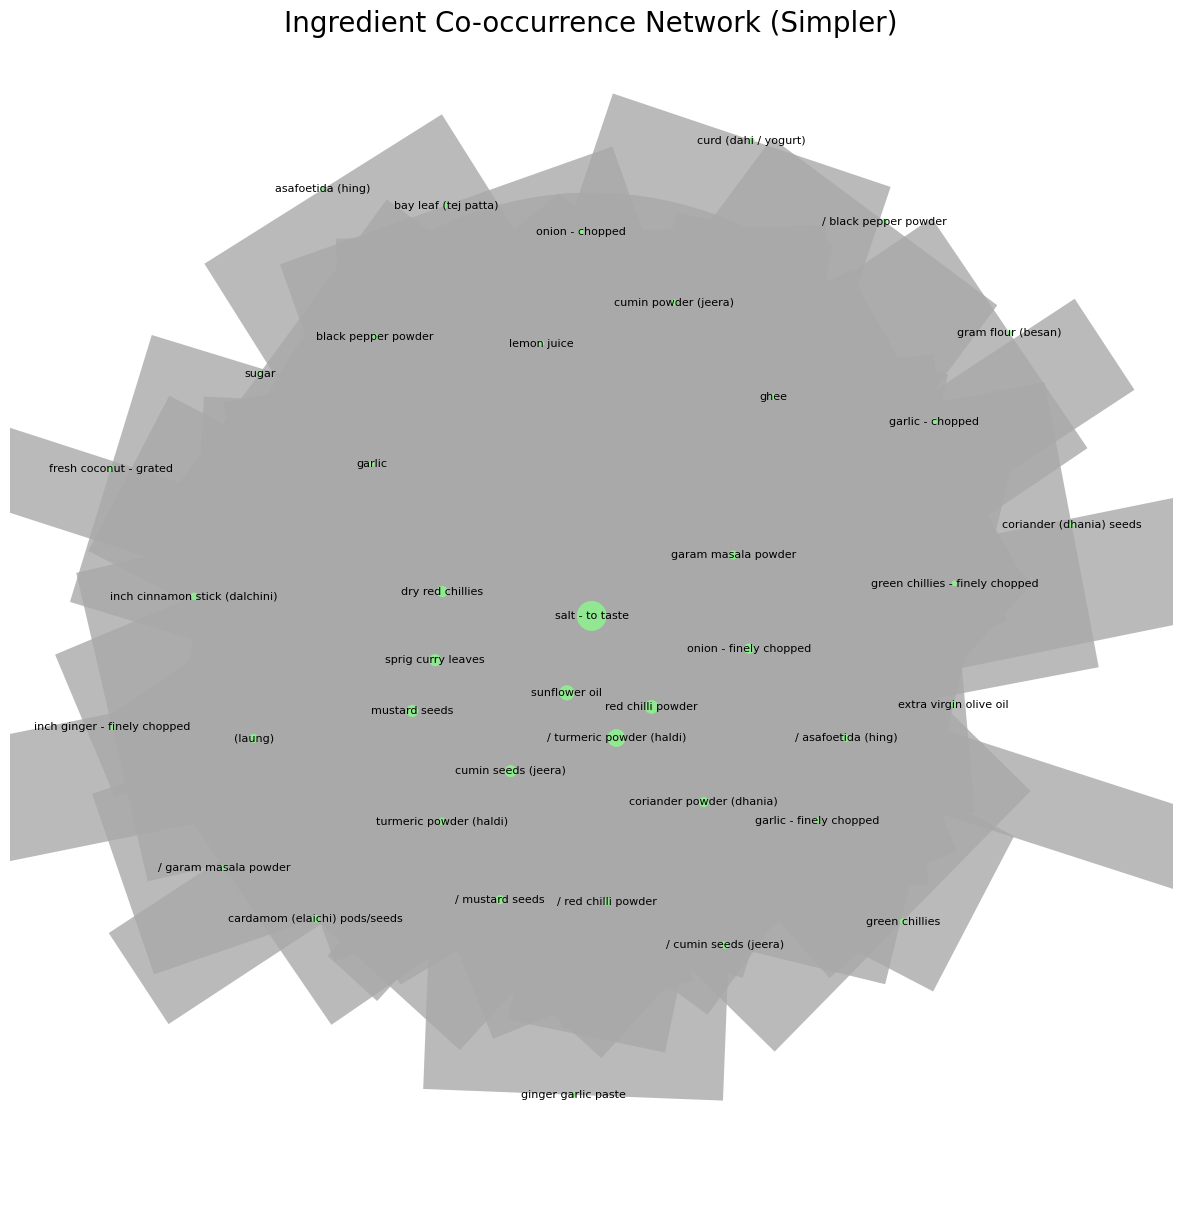

In [30]:
# Save the dense graph to a GML file
output_file = 'ingredient_dense_network.gml'
nx.write_gml(dense_G, output_file)
print(f"Dense graph saved to '{output_file}'.")

# Visualize the dense graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(dense_G, k=0.15, iterations=50, seed=42)

# Draw the nodes, with a size based on degree
node_size = [dense_G.degree(node) * 10 for node in dense_G.nodes()]
nx.draw_networkx_nodes(dense_G, pos, node_color='lightgreen', node_size=node_size, alpha=0.9)

# Draw the edges
# We're multiplying the weight by 2 to make the edges more visible.
# You can adjust this number to change the thickness of the lines.
edge_width = [d['weight'] for u, v, d in dense_G.edges(data=True)]
nx.draw_networkx_edges(dense_G, pos, edge_color='darkgray', width=edge_width, alpha=0.8)

# Draw the labels
nx.draw_networkx_labels(dense_G, pos, font_size=8, font_family='sans-serif')

plt.title("Ingredient Co-occurrence Network (Simpler)", fontsize=20)
plt.axis('off')
plt.show()